In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [3]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [4]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

In [5]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    cumulative_forgetting = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[j]) / (j + 1) for j in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
        _, avg_forgetting = average_forgetting(task_accuracies)
        cumulative_forgetting.append(avg_forgetting)
    print(f"FAA: {np.mean(cumulative_averages, axis=0)[-1]:.2f} ± {np.std(cumulative_averages, axis=0)[-1]:.2f}")
    print(f"Avg. Forgetting: {np.mean(cumulative_forgetting, axis=0):.2f} ± {np.std(cumulative_forgetting, axis=0):.2f}")

    return np.round(np.mean(cumulative_averages, axis=0), decimals=2).tolist()

In [6]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [7]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(accuracy_arrays, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [68]:
def plot_cumulative_subplots(cumulative_averages, subtitles, labels, plot_filename=""):
    assert len(cumulative_averages) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    colors = [
        "#1f77b4",  # tab:blue
        "#d62728",  # tab:red
        "#ff7f0e",  # tab:orange
        "#2ca02c",  # tab:green
    ]

    fig, axes = plt.subplots(1, len(cumulative_averages) // 4, figsize=(20, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                "--o" if j == 0 else "-o",
                # label=f"{labels[j]}: {cumulative_averages[4 * i + j][-1]:.2f}%",
                label=f"{labels[j]}",
                color=colors[j],
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=16)
            axes[i].legend(prop={"size": 14}, loc="upper right")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 71, 10)))

    fig.supxlabel("Task Trained On", fontsize=16)
    fig.supylabel("Accuracy (%)\n", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

Tiny ImageNet 10 Tasks, 20 Classes Per Task

# ER

## Buffer 500

### Without Drift

In [9]:
er_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-500-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-09-10-32-seq-tinyimg-er-buf-500-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-23-25-06-16-34-seq-tinyimg-er-buf-500-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-23-25-03-22-25-seq-tinyimg-er-buf-500-drift-6-s-5-n-4-adaptation-0.json
FAA: 6.26 ± 0.08
Avg. Forgetting: 58.37 ± 0.04


### With Permutation Drift in Tasks 3, 5, 7, 9

In [10]:
er_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-17-59-30-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-23-25-15-08-04-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-23-25-12-03-21-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-0.json
FAA: 6.30 ± 0.03
Avg. Forgetting: 58.16 ± 0.22


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [11]:
er_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-24-25-05-45-20-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/04-24-25-01-53-13-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/04-23-25-22-01-16-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 6.48 ± 0.17
Avg. Forgetting: 55.67 ± 0.46


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [12]:
er_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-24-25-14-28-08-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/04-24-25-11-33-04-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/04-24-25-08-39-13-seq-tinyimg-er-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 6.18 ± 0.10
Avg. Forgetting: 57.17 ± 0.33


### Cumulative Plots

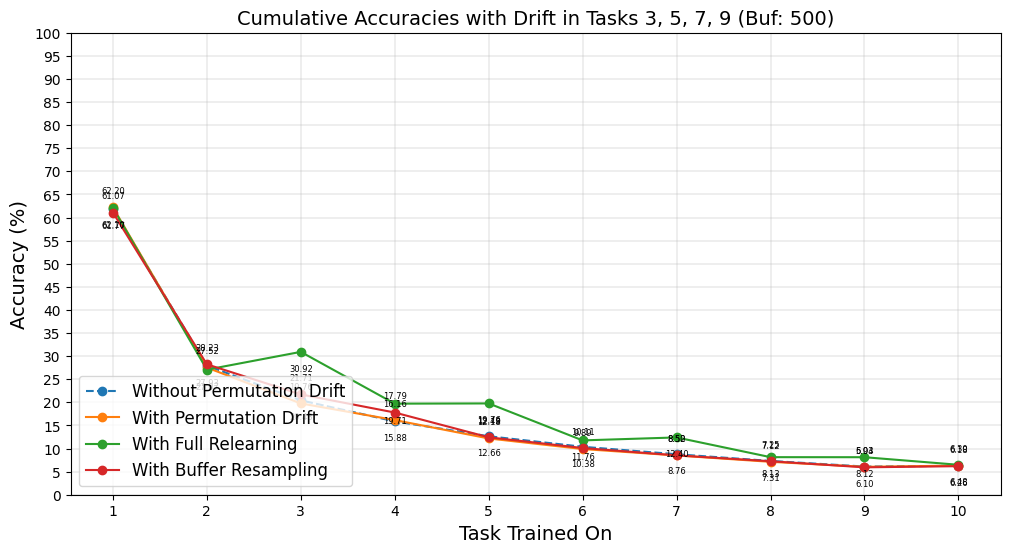

In [13]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [14]:
er_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-5000-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-04-33-58-seq-tinyimg-er-buf-5000-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-23-25-07-28-14-seq-tinyimg-er-buf-5000-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-23-25-10-20-19-seq-tinyimg-er-buf-5000-drift-6-s-5-n-4-adaptation-0.json
FAA: 9.80 ± 0.18
Avg. Forgetting: 58.48 ± 0.13


### With Permutation Drift in Tasks 3, 5, 7, 9

In [15]:
er_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-19-10-41-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-23-25-13-24-57-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-23-25-16-18-21-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-0.json
FAA: 7.12 ± 0.14
Avg. Forgetting: 61.27 ± 0.42


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [16]:
er_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-24-25-04-28-07-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/04-24-25-09-02-56-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/04-23-25-23-51-42-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 9.35 ± 0.17
Avg. Forgetting: 56.19 ± 0.52


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [17]:
er_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-24-25-12-00-31-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/04-24-25-17-55-02-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/04-24-25-14-57-21-seq-tinyimg-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 8.57 ± 0.18
Avg. Forgetting: 58.20 ± 0.48


### Cumulative Plots

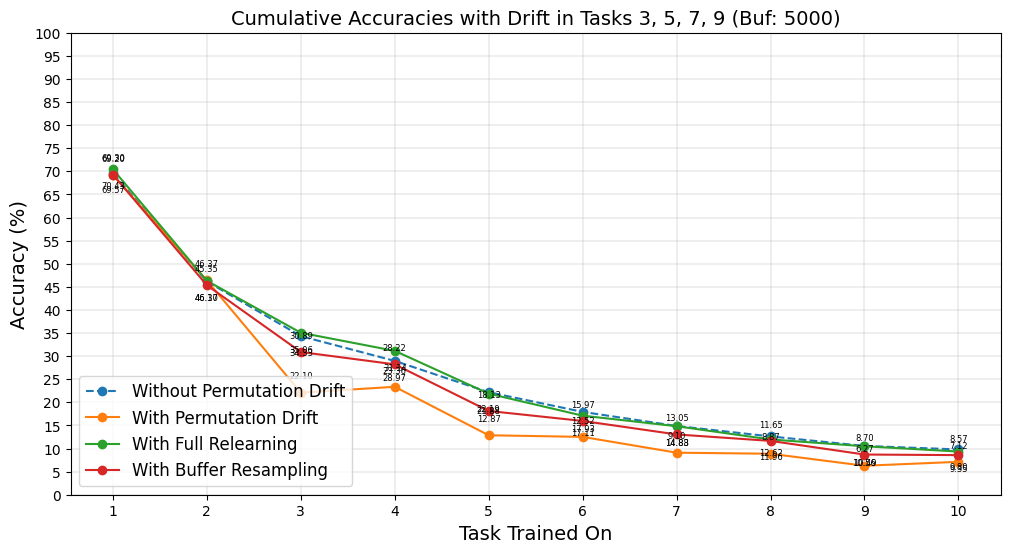

In [18]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Without Drift

In [19]:
er_ace_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-500-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-21-14-54-seq-tinyimg-er_ace-buf-500-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-23-25-15-13-40-seq-tinyimg-er_ace-buf-500-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-23-25-18-12-18-seq-tinyimg-er_ace-buf-500-drift-6-s-5-n-4-adaptation-0.json
FAA: 10.72 ± 0.47
Avg. Forgetting: 32.54 ± 0.61


### With Permutation Drift in Tasks 3, 5, 7, 9

In [20]:
er_ace_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-24-25-03-26-09-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-24-25-06-29-33-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-24-25-00-20-01-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-0.json
FAA: 2.56 ± 0.05
Avg. Forgetting: 41.23 ± 0.12


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [21]:
er_ace_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-24-25-10-58-26-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/04-24-25-20-08-49-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/04-24-25-15-26-59-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 5.46 ± 0.23
Avg. Forgetting: 44.64 ± 0.34


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [22]:
er_ace_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-25-25-04-05-54-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/04-25-25-08-05-05-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/04-25-25-00-07-50-seq-tinyimg-er_ace-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 3.19 ± 0.11
Avg. Forgetting: 41.38 ± 0.24


### Cumulative Plots

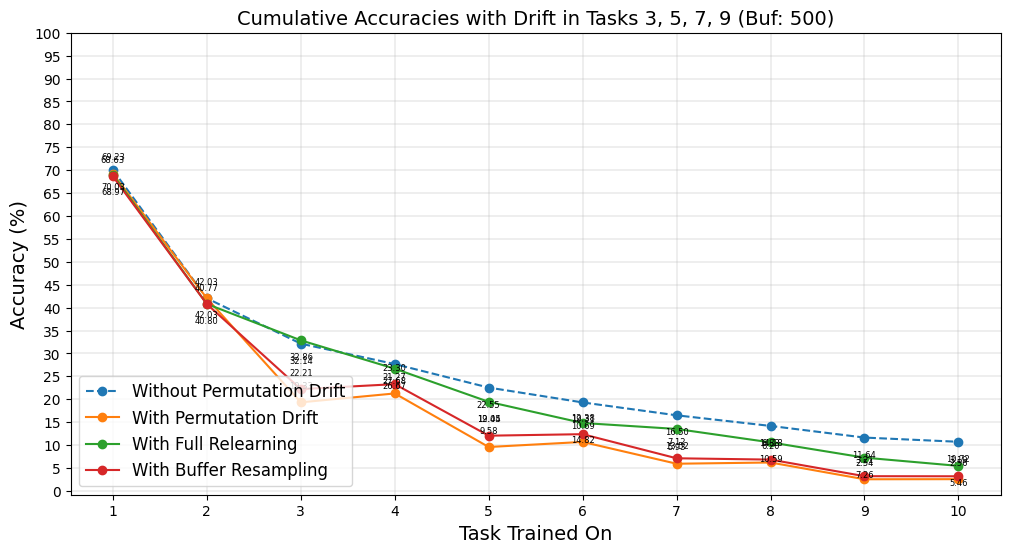

In [23]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [24]:
er_ace_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-5000-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-23-25-12-19-18-seq-tinyimg-er_ace-buf-5000-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-23-25-15-47-51-seq-tinyimg-er_ace-buf-5000-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-23-25-18-45-32-seq-tinyimg-er_ace-buf-5000-drift-6-s-5-n-4-adaptation-0.json
FAA: 16.52 ± 0.31
Avg. Forgetting: 31.99 ± 0.47


### With Permutation Drift in Tasks 3, 5, 7, 9

In [25]:
er_ace_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-24-25-03-54-04-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-24-25-00-50-23-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-23-25-21-46-43-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-0.json
FAA: 5.16 ± 0.17
Avg. Forgetting: 44.78 ± 0.14


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [26]:
er_ace_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/04-24-25-20-28-16-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/04-24-25-14-33-28-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/04-24-25-09-15-00-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 9.23 ± 0.05
Avg. Forgetting: 45.20 ± 0.60


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [27]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/04-25-25-08-28-41-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/04-25-25-00-33-55-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/04-25-25-04-34-44-seq-tinyimg-er_ace-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 7.48 ± 0.08
Avg. Forgetting: 46.96 ± 0.32


### Cumulative Plots

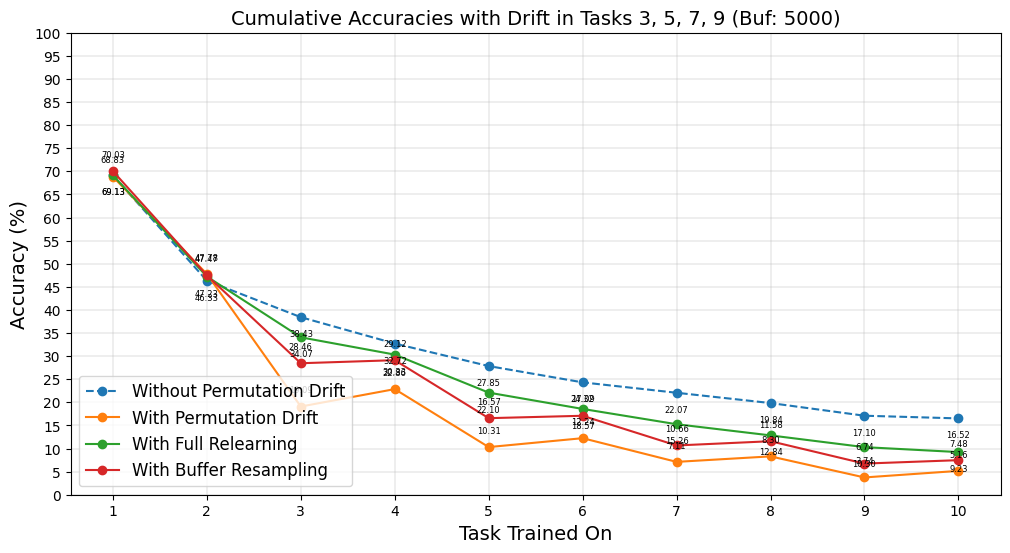

In [28]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# DER++

## Buffer 500

### Without Drift

In [29]:
derpp_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-500-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-29-25-05-31-52-seq-tinyimg-derpp-buf-500-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-28-25-18-04-14-seq-tinyimg-derpp-buf-500-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-28-25-06-36-44-seq-tinyimg-derpp-buf-500-drift-6-s-5-n-4-adaptation-0.json
FAA: 6.37 ± 0.13
Avg. Forgetting: 58.53 ± 0.24


### With Permutation Drift in Tasks 3, 5, 7, 9

In [30]:
derpp_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-03-22-05-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/05-01-25-10-13-06-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/05-01-25-17-13-43-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-0.json
FAA: 6.44 ± 0.07
Avg. Forgetting: 59.03 ± 0.50


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [31]:
derpp_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-02-25-21-56-41-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/05-02-25-02-50-14-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/05-02-25-12-17-41-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 7.97 ± 0.11
Avg. Forgetting: 54.27 ± 0.11


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [32]:
derpp_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-03-25-18-41-21-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/05-03-25-11-44-15-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/05-03-25-04-50-47-seq-tinyimg-derpp-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 6.20 ± 0.08
Avg. Forgetting: 57.37 ± 0.17


### Cumulative Plots

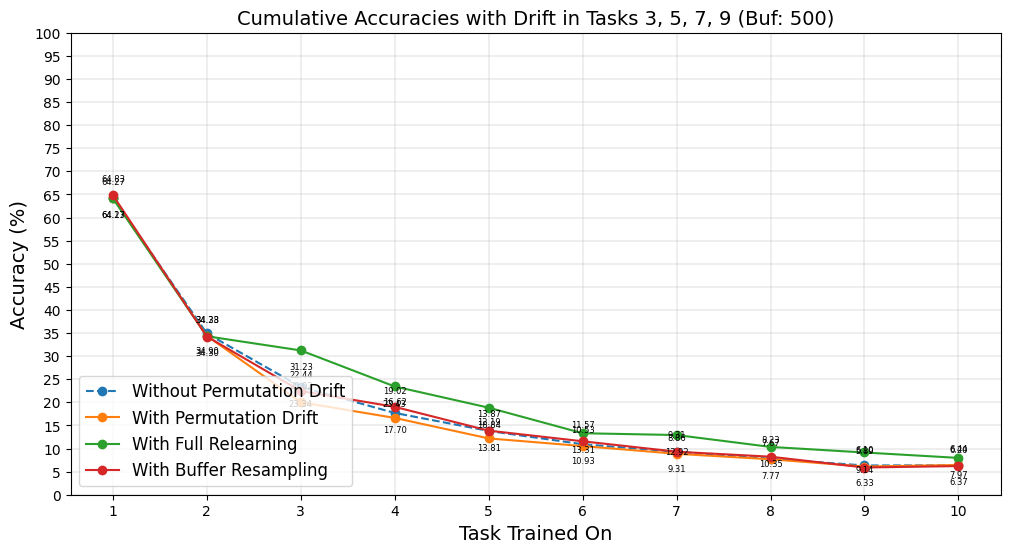

In [33]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [34]:
derpp_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-5000-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/04-29-25-00-17-35-seq-tinyimg-derpp-buf-5000-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/04-28-25-12-43-31-seq-tinyimg-derpp-buf-5000-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/04-29-25-11-50-24-seq-tinyimg-derpp-buf-5000-drift-6-s-5-n-4-adaptation-0.json
FAA: 11.64 ± 0.23
Avg. Forgetting: 36.50 ± 0.49


### With Permutation Drift in Tasks 3, 5, 7, 9

In [35]:
derpp_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-01-25-03-20-31-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/05-01-25-17-07-30-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/05-01-25-10-10-55-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-0.json
FAA: 5.38 ± 0.15
Avg. Forgetting: 43.10 ± 0.70


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [36]:
derpp_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-02-25-04-24-07-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/05-02-25-15-46-16-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/05-03-25-03-12-36-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 8.82 ± 0.12
Avg. Forgetting: 41.06 ± 1.81


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [37]:
derpp_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-03-25-10-07-37-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/05-04-25-00-02-11-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/05-03-25-17-07-04-seq-tinyimg-derpp-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 8.04 ± 0.17
Avg. Forgetting: 53.03 ± 0.23


### Cumulative Plots

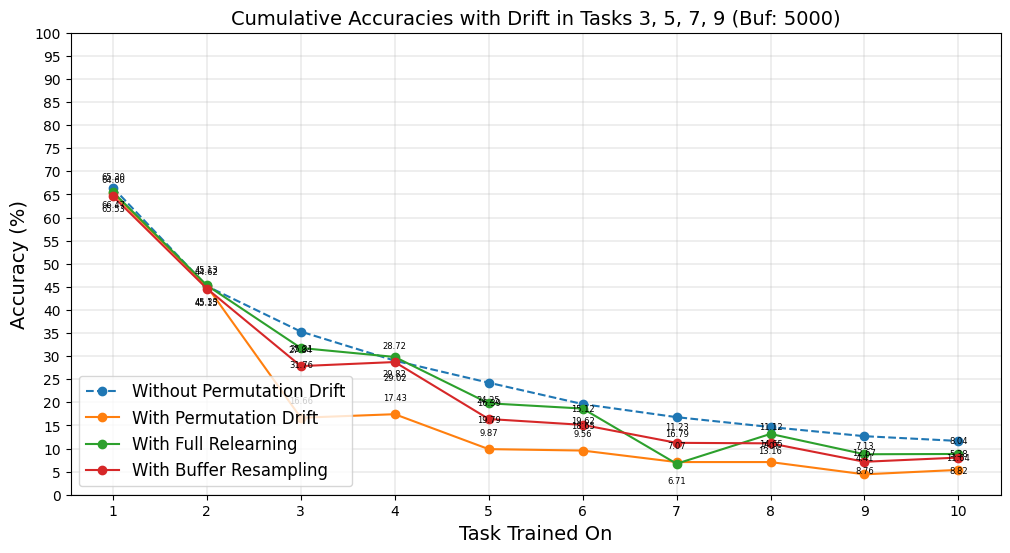

In [38]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# SER

## Buffer 500

### Without Drift

In [39]:
ser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-500-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-05-11-38-seq-tinyimg-ser-buf-500-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/05-04-25-09-31-10-seq-tinyimg-ser-buf-500-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/05-04-25-00-51-41-seq-tinyimg-ser-buf-500-drift-6-s-5-n-4-adaptation-0.json
FAA: 16.18 ± 0.72
Avg. Forgetting: 21.93 ± 0.44


### With Permutation Drift in Tasks 3, 5, 7, 9

In [40]:
ser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-22-34-24-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/05-04-25-13-47-35-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/05-04-25-18-02-44-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-0.json
FAA: 6.86 ± 0.15
Avg. Forgetting: 32.29 ± 0.78


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [41]:
ser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-04-53-57-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/05-05-25-11-14-11-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/05-05-25-17-40-00-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 8.71 ± 0.33
Avg. Forgetting: 31.77 ± 0.41


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [42]:
ser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-09-06-46-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/05-05-25-22-34-54-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/05-06-25-03-54-19-seq-tinyimg-ser-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 4.73 ± 0.22
Avg. Forgetting: 26.84 ± 0.17


### Cumulative Plots

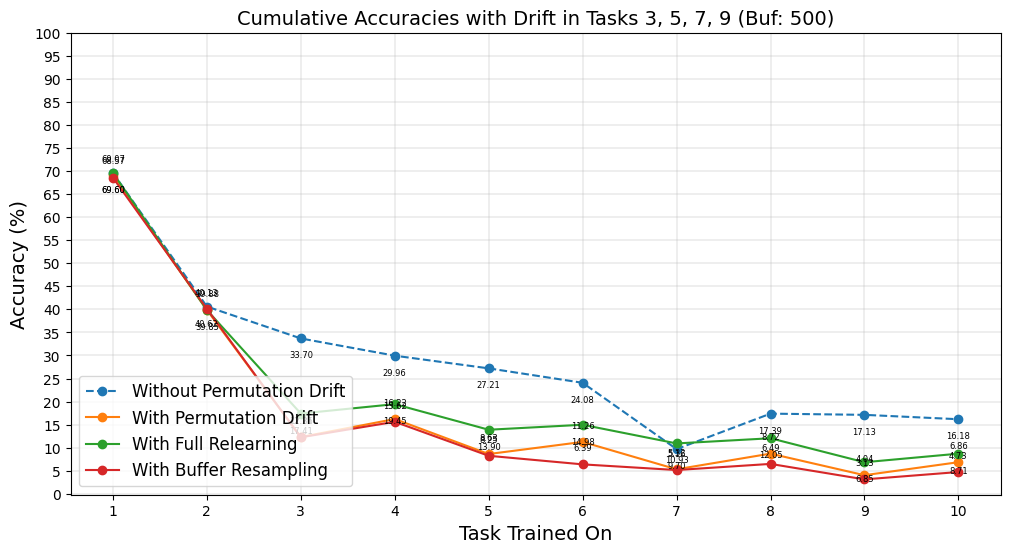

In [43]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [44]:
ser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-5000-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-04-09-08-seq-tinyimg-ser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/05-04-25-12-48-33-seq-tinyimg-ser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/05-04-25-08-30-09-seq-tinyimg-ser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
FAA: 16.31 ± 0.51
Avg. Forgetting: 10.78 ± 0.45


### With Permutation Drift in Tasks 3, 5, 7, 9

In [45]:
ser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-01-53-14-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/05-04-25-17-00-32-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/05-04-25-21-23-39-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
FAA: 4.84 ± 0.29
Avg. Forgetting: 23.95 ± 0.36


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [46]:
ser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-17-12-25-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/05-06-25-01-22-24-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/05-05-25-09-32-33-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 7.63 ± 0.04
Avg. Forgetting: 21.91 ± 0.43


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [47]:
ser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-11-56-39-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/05-06-25-06-41-07-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/05-06-25-16-57-11-seq-tinyimg-ser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 6.84 ± 0.26
Avg. Forgetting: 31.33 ± 0.23


### Cumulative Plots

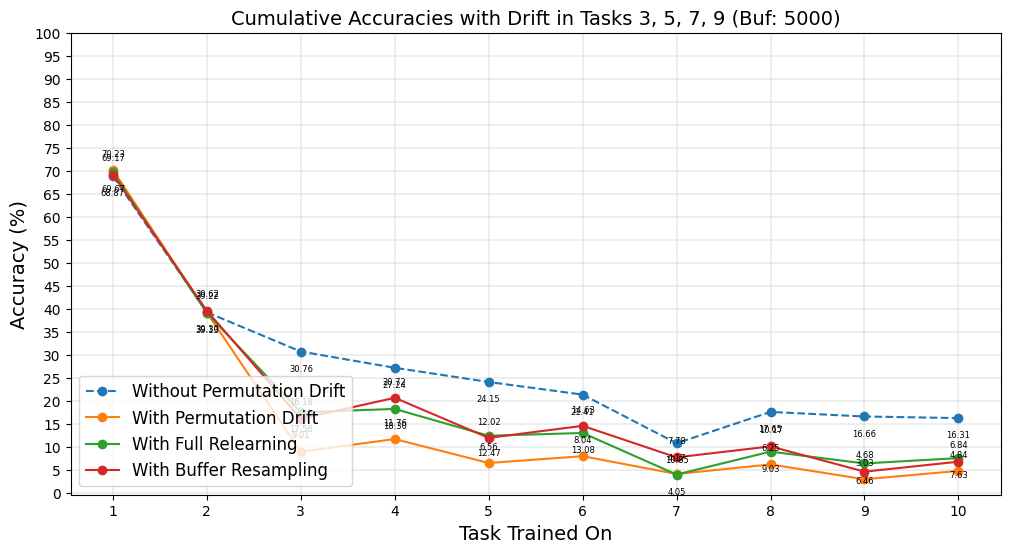

In [48]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# CLSER

## Buffer 500

### Without Drift

In [49]:
clser_500_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-500-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-03-25-09-24-27-seq-tinyimg-clser-buf-500-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/05-03-25-13-48-47-seq-tinyimg-clser-buf-500-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/05-03-25-04-50-37-seq-tinyimg-clser-buf-500-drift-6-s-5-n-4-adaptation-0.json
FAA: 6.21 ± 0.07
Avg. Forgetting: 57.10 ± 0.23


### With Permutation Drift in Tasks 3, 5, 7, 9

In [50]:
clser_500_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-03-13-01-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/05-03-25-22-43-40-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/05-03-25-18-16-40-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-0.json
FAA: 6.16 ± 0.27
Avg. Forgetting: 57.21 ± 0.30


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [51]:
clser_500_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-04-25-15-58-19-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/05-04-25-22-22-48-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/05-04-25-09-37-34-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-1.json
FAA: 8.72 ± 0.03
Avg. Forgetting: 53.56 ± 0.18


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [52]:
clser_500_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-05-25-12-28-03-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/05-05-25-03-05-44-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/05-05-25-07-47-43-seq-tinyimg-clser-buf-500-drift-5-s-5-n-4-adaptation-2.json
FAA: 7.30 ± 0.08
Avg. Forgetting: 56.29 ± 0.56


### Cumulative Plots

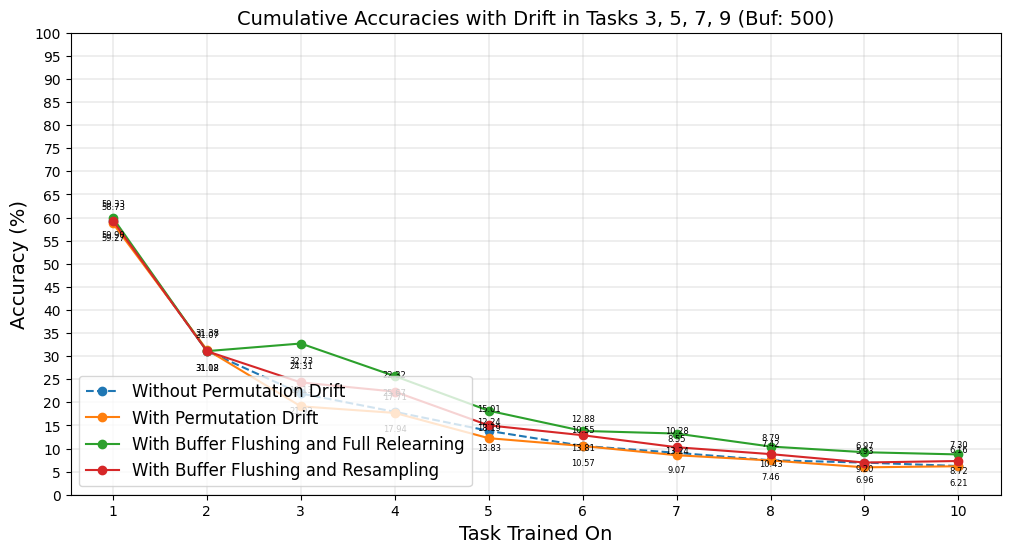

In [53]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 500)",
    [
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Without Drift

In [54]:
clser_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-5000-drift-6-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-06-25-03-43-23-seq-tinyimg-clser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/05-06-25-16-42-03-seq-tinyimg-clser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/05-07-25-05-43-02-seq-tinyimg-clser-buf-5000-drift-6-s-5-n-4-adaptation-0.json
FAA: 16.06 ± 0.41
Avg. Forgetting: 39.50 ± 0.36


### With Permutation Drift in Tasks 3, 5, 7, 9

In [55]:
clser_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-0.json"
)

3 files found
1: ./reimplementation-logs/05-07-25-06-02-13-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
2: ./reimplementation-logs/05-06-25-03-50-01-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
3: ./reimplementation-logs/05-06-25-16-55-57-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-0.json
FAA: 7.41 ± 0.13
Avg. Forgetting: 49.77 ± 0.18


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [56]:
clser_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

3 files found
1: ./reimplementation-logs/05-07-25-08-50-57-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
2: ./reimplementation-logs/05-06-25-11-46-42-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
3: ./reimplementation-logs/05-08-25-05-56-21-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 11.13 ± 0.14
Avg. Forgetting: 47.10 ± 0.69


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [57]:
clser_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

3 files found
1: ./reimplementation-logs/05-07-25-06-25-23-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
2: ./reimplementation-logs/05-06-25-03-57-59-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
3: ./reimplementation-logs/05-06-25-17-12-05-seq-tinyimg-clser-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 10.78 ± 0.30
Avg. Forgetting: 48.96 ± 0.69


### Cumulative Plots

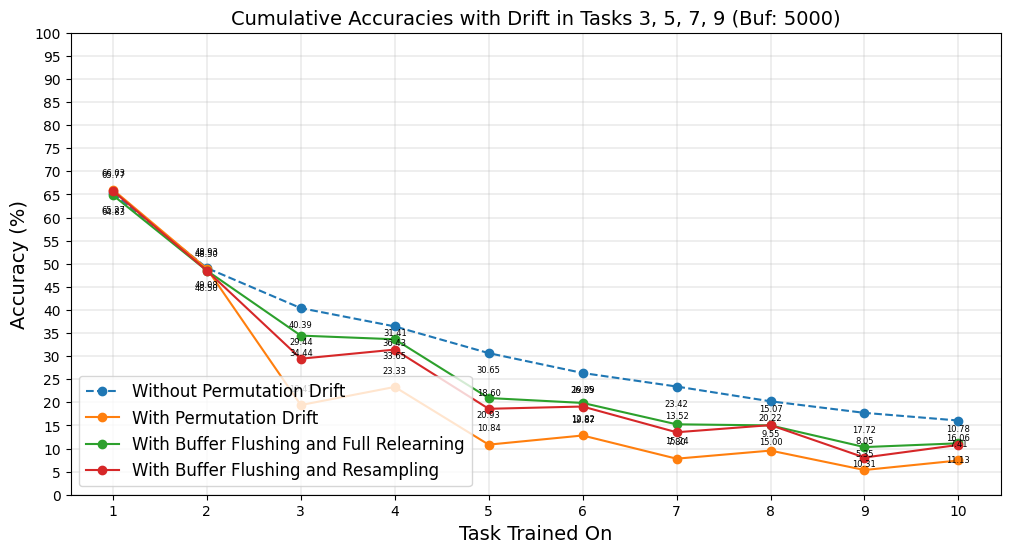

In [58]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000)",
    [
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Relearning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

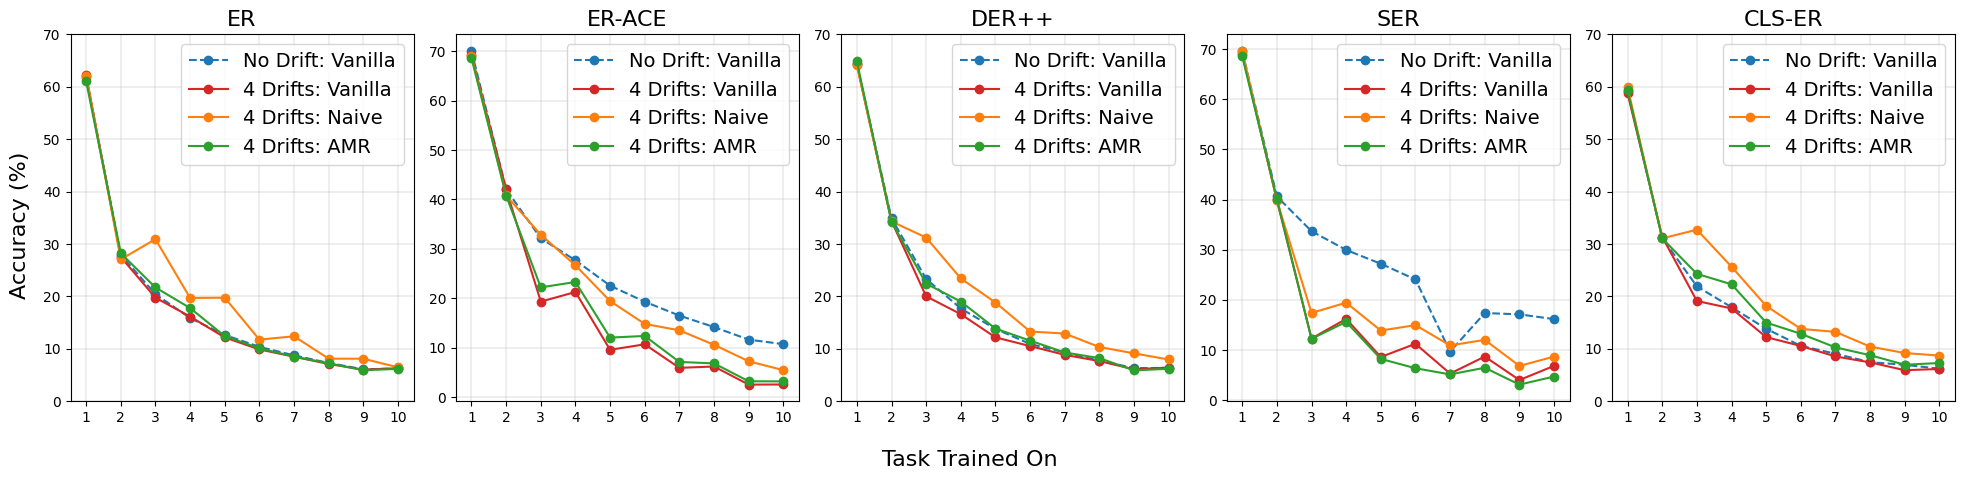

In [69]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
        ser_500_accuracy_array_without_drift,
        ser_500_accuracy_array_with_drift,
        ser_500_accuracy_array_with_drift_full_relearning,
        ser_500_accuracy_array_with_drift_buffer_resampling,
        clser_500_accuracy_array_without_drift,
        clser_500_accuracy_array_with_drift,
        clser_500_accuracy_array_with_drift_full_relearning,
        clser_500_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "4 Drifts: Vanilla",
        "4 Drifts: Naive",
        "4 Drifts: AMR",
    ],
    # plot_filename="TinyImg_Buff_500_n_4.pdf",
)

## Buffer 5000

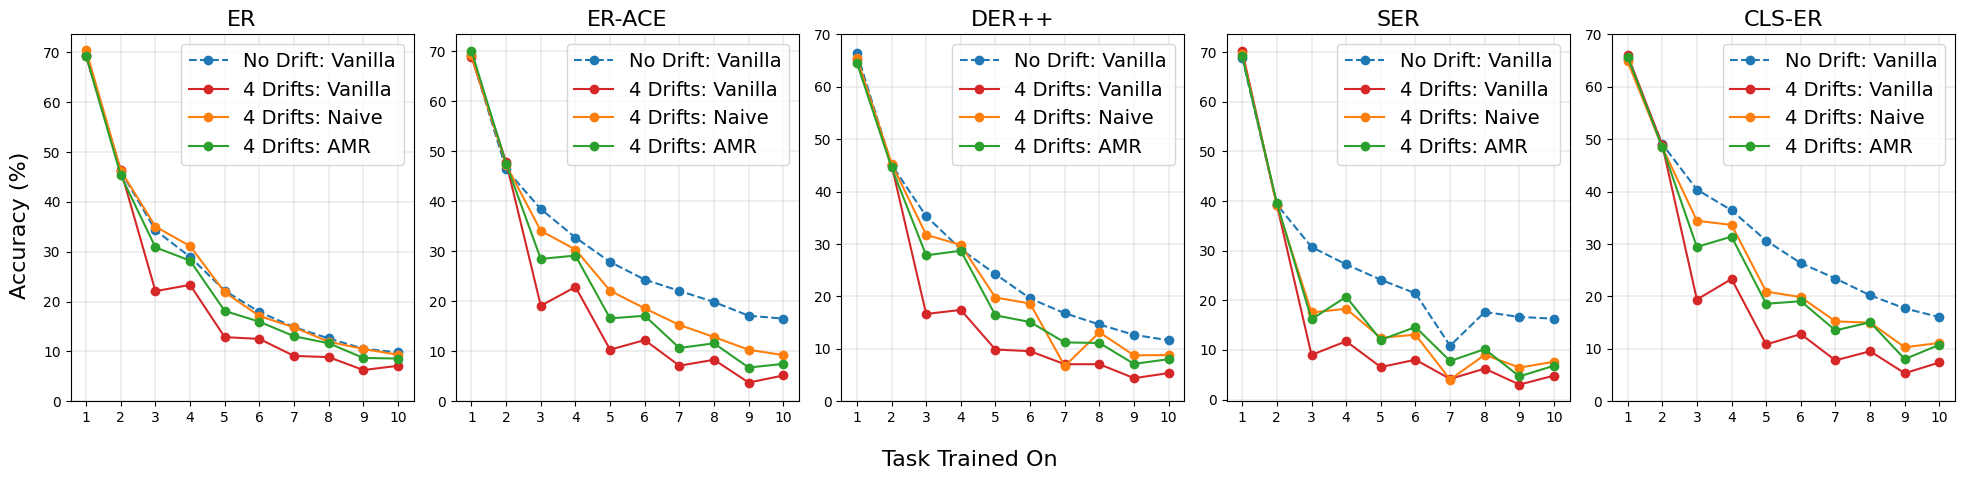

In [70]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
        ser_5000_accuracy_array_without_drift,
        ser_5000_accuracy_array_with_drift,
        ser_5000_accuracy_array_with_drift_full_relearning,
        ser_5000_accuracy_array_with_drift_buffer_resampling,
        clser_5000_accuracy_array_without_drift,
        clser_5000_accuracy_array_with_drift,
        clser_5000_accuracy_array_with_drift_full_relearning,
        clser_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ER", "ER-ACE", "DER++", "SER", "CLS-ER"],
    [
        "No Drift: Vanilla",
        "4 Drifts: Vanilla",
        "4 Drifts: Naive",
        "4 Drifts: AMR",
    ],
    plot_filename="TinyImg_Buff_5000_n_4.pdf",
)